## Get data
`!sudo wget https://download.openmmlab.com/datasets/movienet/poster4M.img_meta.v1.json`

## Install FaceNet

**With pip:**
`!sudo pip install facenet-pytorch`

**or clone this repo, removing the '-' to allow python imports:**

`!sudo git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch`

**or use a docker container (see https://github.com/timesler/docker-jupyter-dl-gpu):**

`!sudo docker run -it --rm timesler/jupyter-dl-gpu pip install facenet-pytorch && ipython`

In [5]:
import json

img_meta = json.load(open('poster4M.img_meta.v1.json'))

{'img': '0000/rm0301568.jpg', 'w': 400, 'h': 268, 'type': 'event', 'cast': ['nm0000102'], 'movie': ['tt0804461'], 'url': 'https://m.media-amazon.com/images/M/MV5BMjA4MDI4NzU1MV5BMl5BanBnXkFtZTYwNzI0NTgz._V1_.jpg'}


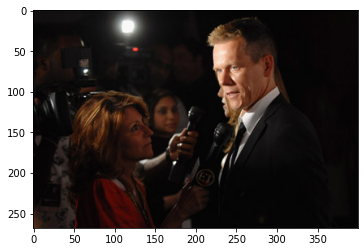

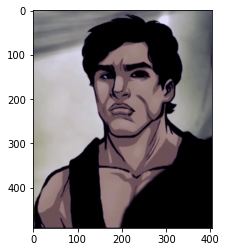

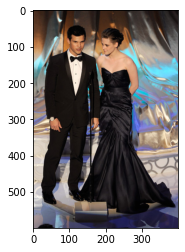

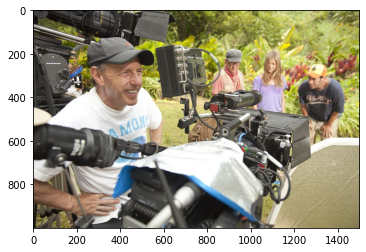

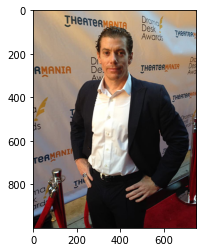

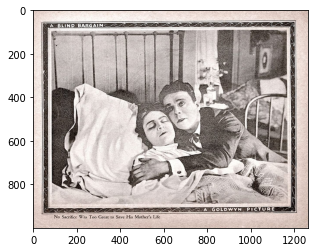

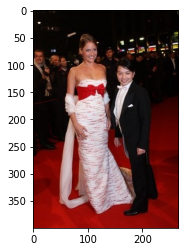

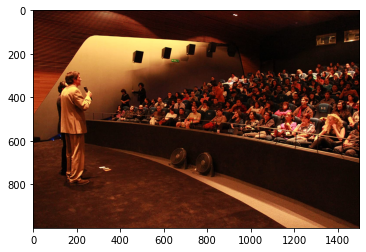

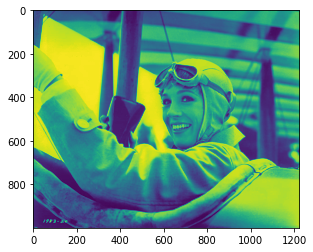

In [59]:
import os
import shutil
import requests
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

shutil.rmtree('data')
os.mkdir('data')
for i, image in enumerate(img_meta):
    url = img_meta[image]['url']
    r = requests.get(url, stream=True)
    try:
        img = Image.open(r.raw)
        plt.imshow(img)
        plt.show()
        with open(f'data/{image}.jpg', 'wb') as out_file:
#             shutil.copyfileobj(r.raw, out_file)
            out_file.write(r.content)
    except Image.UnidentifiedImageError:
        continue
    if i == 10:
        break

In [60]:
img = Image.open(f'data/{os.listdir("data")[0]}')
plt.imshow(img)
plt.show()

UnidentifiedImageError: cannot identify image file 'data/rm1022028800.jpg'

In [33]:
img_meta

{'rm0301568': {'img': '0000/rm0301568.jpg',
  'w': 400,
  'h': 268,
  'type': 'event',
  'cast': ['nm0000102'],
  'movie': ['tt0804461'],
  'url': 'https://m.media-amazon.com/images/M/MV5BMjA4MDI4NzU1MV5BMl5BanBnXkFtZTYwNzI0NTgz._V1_.jpg'},
 'rm1008092672': {'img': '0000/rm1008092672.jpg',
  'w': 1375,
  'h': 1000,
  'type': 'poster',
  'cast': ['nm0314524'],
  'movie': ['tt0118254', 'tt0510288'],
  'url': 'https://m.media-amazon.com/images/M/MV5BZjZiYTE2ZWMtZDk4OC00MTY0LTg0MzEtOTk2ODlhMDQ1ZGNkXkEyXkFqcGdeQXVyNzg4MzA5ODQ@._V1_SY1000_CR0,0,1375,1000_AL_.jpg'},
 'rm1010795520': {'img': '0000/rm1010795520.jpg',
  'w': 404,
  'h': 491,
  'type': 'publicity',
  'cast': ['nm0037423'],
  'movie': ['tt1728933'],
  'url': 'https://m.media-amazon.com/images/M/MV5BMTk4ODI5MTkzMF5BMl5BanBnXkFtZTcwODU1MjYyNA@@._V1_.jpg'},
 'rm1011876608': {'img': '0000/rm1011876608.jpg',
  'w': 703,
  'h': 1000,
  'type': 'publicity',
  'cast': ['nm4001404'],
  'movie': [],
  'url': 'https://m.media-amazon.com/imag

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=<image_size>, margin=<margin>)

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [ ]:
import urllib.request
from PIL import Image


urllib.request.urlretrieve(url, f'{i}.jpg')
  
img = Image.open("gfg.png")
img.show()
img = Image.open(<image path>)

# Get cropped and prewhitened image tensor
img_cropped = mtcnn(img, save_path=<optional save path>)

# Calculate embedding (unsqueeze to add batch dimension)
img_embedding = resnet(img_cropped.unsqueeze(0))

# Or, if using for VGGFace2 classification
resnet.classify = True
img_probs = resnet(img_cropped.unsqueeze(0))